# Experiments with the Interaction Decomposition


In this notebook, we see how the _interaction decomposition_ from [Convy and Whaley (2023)](https://iopscience.iop.org/article/10.1088/2632-2153/aca271) can be used for tensor network machine learning. The focus here will be on key procedural steps and examples, with the bulk of the working code being imported from local modules `data.py`, `models.py`, `factor.py`, and `cnn.py`.  

## A brief introduction to tensor network machine learning

Tensor network machine learning is a fairly new area of ML research, in which a model is constructed out of a network of parameterized tensors. A _tensor_ is best understood as a multidimensional array of numbers, which generalizes the matrix and vector objects from linear algebra. The number of dimensions in a tensor is referred to as its _order_, such that a vector is a first-order (1D) tensor and a matrix is a second-order (2D) tensor. Machine learning models can be built by joining multiple tensors together in a graph or network, with each edge of the graph denoting the multiplication of the tensors on the connected nodes.

While a detailed description of tensor network machine learning is beyond the scope of this notebook, the basic pipeline can be summarized in the following steps:

1. Implicitly transform the feature vectors of the target dataset into elements of an exponentially large space
2. Multiply these transformed samples by the tensors in the network which parameterize the model
3. Optimize the elements of those tensors using the output of the tensor multiplication
4. Repeat steps 1-3 until the loss function converges.

In practice, we can implement these steps easily using the Keras API in TensorFlow (or another ML package) with custom layers for steps 1 and 2.  

### An example tensor network model

In the following code block, we can see a custom Keras layer that implements the first step in our procedure:

In [1]:
import tensorflow as tf

class Pow_Feat_Layer(tf.keras.layers.Layer):
    def __init__(self, max_power, dtype = "float32"):
        super().__init__(dtype = dtype)
        self.powers = tf.range(max_power + 1, dtype = dtype)[None, None]

    def call(self, inputs):
        output = inputs[..., None] ** self.powers
        return output   

This class inherits from the Keras `Layer` class, and operates by expanding the $n \times m$ batch of feature vectors into an $n\times m \times p + 1$ batch of feature matrices. For a given sample matrix, the $i$th row has the form $[1, x_i, x^2_i,...,x^p_i]$, where $x_i$ is the $i$th data feature and $p$ is the maximum power. Implicitly, we view the sample matrix as representing a tensor formed from the tensor product of each row, which would be an element of a massive $p^m$-dimensional tensor space. 

For step 2, can implement another custom Keras layer that carries out the tensor multiplication of our network with the output from `Pow_Feat_Layer`. The following code block provides an example of such a layer:

In [2]:
import tensorflow as tf

class MPS_Layer(tf.keras.layers.Layer):
    def __init__(self, bond_dim, num_classes, dtype = "float32"):
        super().__init__(dtype = dtype)
        self.bond_dim = bond_dim
        self.num_classes = num_classes
        self.set_decomp(False)

    def build(self, input_shape):
        (_, num_sites, phy_dim) = input_shape[:3]
        self.num_sites = num_sites
        self.split = tf.Variable(num_sites // 2, trainable = False) # The output is placed in the middle
        self.matrix_weights = self.add_weight("matrix_weights",
            [phy_dim, num_sites, self.bond_dim, self.bond_dim], self.dtype, self.initializer)
        self.middle = self.add_weight("middle", # This tensor is the output component of the network
            [self.num_classes, self.bond_dim, self.bond_dim], self.dtype, self.middle_initializer)

    def call(self, inputs, **kwargs):

        # This function generates a prediction on the passed input batch.

        split_data = tf.concat([inputs[:, self.split:], inputs[:, :self.split]], 1)
        matrices = tf.einsum("nij,jikl->inkl", split_data, self.matrix_weights)
        matrix_prod = self.reduction(matrices)
        outputs = tf.einsum("nkl,olk->no", matrix_prod, self.middle)
        return outputs

    @staticmethod
    def initializer(shape, dtype):

        # This function initializes the component tensors of the network.
        # The tensors need to be initialized such that they basically act 
        # like the identity.
        
        (phys_dim, num_sites, bond_dim, bond_dim) = shape
        bias = tf.tile(tf.eye(bond_dim, dtype = dtype)[None, None], (1, num_sites, 1, 1))
        kernel = tf.random.normal([phys_dim - 1, num_sites, bond_dim, bond_dim], 0, 1e-2, dtype)
        weights = tf.concat([bias, kernel], 0)
        return weights

    @staticmethod
    def middle_initializer(shape, dtype):
        
        # This function initializes the output component tensor.

        (num_sites, bond_dim, bond_dim) = shape
        weights = tf.tile([tf.eye(bond_dim, dtype = dtype)], (num_sites, 1, 1))
        noised = weights + tf.random.normal(weights.shape, 0, 1e-2, dtype = dtype)
        return noised

    @staticmethod
    def reduction(tensor):

        # This function performs an efficient contraction of the MPS
        # component matrices generated by contraction with the data
        # vectors.

        size = int(tensor.shape[0])
        while size > 1:
            half_size = size // 2
            nice_size = 2 * half_size
            leftover = tensor[nice_size:]
            tensor = tf.matmul(tensor[0:nice_size:2], tensor[1:nice_size:2])
            tensor = tf.concat([tensor, leftover], axis = 0)
            size = half_size + int(size % 2 == 1)
        return tensor[0]

As before, this layer inherits from the Keras `Layer` base class, and overloads the `build` and `call` methods. The `self.matrix_weights` array holds the parameters of the tensor network model, with each slice along the first dimension corresponding to a third-order tensor on one of the graph nodes. There are many different kinds of tensor networks, with this layer implementing a matrix product state (MPS) architecture. Note that custom initialization functions are needed in order to generate a numerically-stable output, and that the tensor multiplication can be performed efficiently in parallel. Once an output is generated, the parameters in `self.matrix_weights` (and `self.middle`) can be optimized in step 3 using stochastic gradient descent as would be done for a neural network.

## The interaction decomposition

For a tensor network regression model using `Pow_Feat_layer` with $p = 1$ (which is most common), the prediction $y$ for sample vector $\vec{x}$ is given by

\begin{equation}
y = w_0 + \sum^m_{i=1}w_ix_i + \sum^{m-1}_{i=1}\sum^m_{j = i+1}w_{ij}x_ix_j + ... + w_{1,2,...,m}x_1x_2\cdots x_m,
\end{equation}

which is linear regression (with coefficients $w$ generated by the tensor multiplication) on every possible product of the original features. In an interaction decomposition, we explicitly separate out contributions to $y$ based on the number of features multiplied together in the regressors. This _interaction degree_ ranges from 0 in the bias term $w_0$ to $m$ in the term $w_{1,2,...,m}x_1x_2\cdots x_m$ which is the product of all features. Once the different interactions are disentangled, we can analyze their properties and modify their values individually.

It turns out that the interaction decomposition can be implemented in a fairly straightforward manner by tweaking how the tensor operations are performed. The following code block performs an interaction decomposition for the MPS model shown previously:

In [3]:
import tensorflow as tf

def decomp(self, inputs, indices, **kwargs):
    max_order = indices[-1].shape[0]
    split_data = tf.concat([inputs[:, self.split:], inputs[:, :self.split]], 1)
    order_matrices = tf.einsum("nsrj,jskl->rnskl", split_data, self.matrix_weights)
    cuml = order_matrices[:, :, 0]
    for i in range(1, self.num_sites):
        order_matrix = order_matrices[:, :, i]
        contract = tf.einsum("rnkl,qnlm->qrnkm", cuml, order_matrix)
        combined = contract[0, 1:] + contract[1, :-1]
        cuml = tf.concat([contract[0, :1], combined, contract[1, -1:]], 0)[:max_order]
    order_output = tf.einsum("rnlm,oml->nor", cuml, self.middle)
    return order_output

The key modification is that each tensor is given an extra dimension which separates the different interaction degrees. When two tensors are multiplied together, the slices along this extra dimension are matched up and summed together to preserve the interaction degree. 

## Numerical experiments

We will now perform numerical tests using the interaction decomposition on two different tensor network models: the MPS introduced previously, and a binary tree network called a TTN. We will train these models to classify images from the MNIST and Fashion MNIST datasets, though we will shrink them down from $28 \times 28$ to $8 \times 8$ to speed up our computations. The following code retrieves and plots a pair of example images:

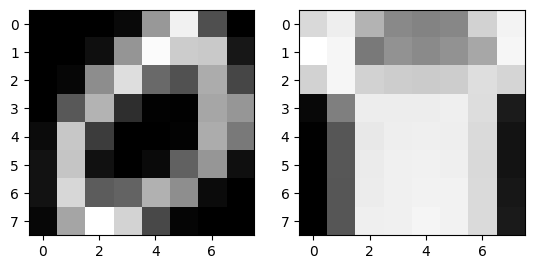

In [4]:
import tensorflow as tf
from skimage import transform
import matplotlib.pyplot as plt

def get_example_image(fashion = False):
    if fashion:
        image = tf.keras.datasets.fashion_mnist.load_data()[0][0][1]
    else:
        image = tf.keras.datasets.mnist.load_data()[0][0][1]
    image = image / 255
    image = image[4:24, 4:24] # Remove black border before resizing
    image = transform.resize(image, (8, 8)) - 0.5
    return image

mnist_image = get_example_image()
fashion_image = get_example_image(fashion = True)

(fig, axes) = plt.subplots(1, 2)
axes[0].imshow(mnist_image, cmap = "gray")
axes[1].imshow(fashion_image, cmap = "gray")
plt.show()

Note that both images are largely recognizable after being shrunk, though this can vary depending on the image for Fashion MNIST. 

### CNN baseline

To get a sense of how difficult these two transformed datasets are to classify, we can run an experiment using an Inception-based CNN classifier as a state-of-the-art comparison point. The following code imports the model architecture from `cnn.py` and then trains it for 50 epochs on either MNIST or Fashion MNIST as specified. 

In [ ]:
import tensorflow as tf

from src import data, cnn

fashion = False

data_function = data.get_fashion_data if fashion else data.get_mnist_data
((x_train, y_train), (x_test, y_test)) = data_function(border = False, size = (8, 8))
x_train = tf.reshape(x_train, [-1, 8, 8])
x_test = tf.reshape(x_test, [-1, 8, 8])
x_train = tf.tile(x_train[..., None], (1, 1, 1, 3))
x_test = tf.tile(x_test[..., None], (1, 1, 1, 3))

model = cnn.build_inception(x_train)
model.compile(loss = 'categorical_crossentropy', 
                optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.006, beta_1 = 0.49, beta_2 = 0.999),
                metrics = ['accuracy'])
model.fit(x_train, y_train, 64, 50, validation_split = 1/6, verbose = 1)
score = model.evaluate(x_test, y_test, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

After training, we find accuracies of 99.2-99.3% on MNIST and accuracies of 86.4-86.8% on Fashion MNIST. This shows that the $8 \times 8$ Fashion MNIST images are significantly harder to classify than the full $28 \times 28$ images, while MNIST does not seem to have been affected much by the resizing.

### MPS and TTN models

The next models that we will test are the regular MPS and TTN tensor network models. For this initial set of experiments, we will perform the tensor operations normally during training, and then carry out the interaction decomposition at the end on the test dataset. The following code imports the tensor network models from `models.py`, trains them, and then saves the results. There are four different training combinations that can be selected, using either an MPS or TTN model and either MNIST or Fashion MNIST for training. 

In [ ]:
import tensorflow as tf

from src import data, factor, models

model_name = "ttn" # either "mps" or "ttn"
dataset = "fashion" # either "mnist" or "fashion"
save = True

((train_x, train_y), (test_x, test_y), num_classes) = data.get_dataset(
        dataset, size = (8, 8), border = False)
model = models.get_model(model_name, num_classes, dtype = "float64", bond_dim = 20)
model.compile(loss = "mse",
    optimizer = tf.keras.optimizers.RMSprop(1e-3),
    metrics = ['accuracy'],
    run_eagerly = False)
model.fit(train_x, train_y,
    batch_size = 128,
    epochs = 100,
    verbose = 1,
    validation_split = 1/6)

score = model.evaluate(test_x, test_y, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

if save:
    save_path = f"src/saved/{model_name}_{dataset}"
    model_string = f"/{model_name}_{num_classes}_20_float64"
    model.save_weights(save_path + model_string, save_format = "tf")
    print("Computing interaction degrees...")
    factor.factorize(save_path, (test_x, test_y))
    print("\nComplete.")

The contributions from the different interaction degrees for each test sample are saved in the `factor.npz` compressed NumPy archive. These results can be aggregated into a more interpretable form by the following two functions:

In [9]:
import tensorflow as tf
import numpy as np

def get_labeled_order_acc(path):
    data = np.load(path + "/factors.npz")
    pred = np.argmax(data["results"], 1)
    labels = np.argmax(data["labels"], -1)[:, None]
    accs = (pred == labels).mean(0)
    return tf.convert_to_tensor(accs)

def get_labeled_cuml_acc(path):
    data = np.load(path + "/factors.npz")
    labels = np.argmax(data["labels"], -1)[:, None]
    cum_factors = np.cumsum(data["results"], -1)
    pred = np.argmax(cum_factors, 1)
    accs = (pred == labels).mean(0)
    return tf.convert_to_tensor(accs)

These functions compute two different kinds of accuracy values with respect to the interaction decomposition. To get the accuracy of the interaction degrees individually, we use `get_labeled_order_acc` to compare the argmax for the prediction with the true label for each degree. To get the accuracy of the sum of all interaction degrees less than or equal to a given value, we use `get_labeled_cuml_acc` which sums the different predictions before taking the argmax. When these accuracy values are averaged across ten different model instantiations, we get the following plot:

<img src="figures/accs.png"  width="850">

where "TR" stands for "tensor ring", which is a more precise term for our MPS model. The solid lines mark the cumulative accuracy of the interaction degrees, while the scatter plot points mark the individual accuracies of each degree. These plots show that the cumulative accuracies require half or more of the interaction degrees before converging to the final accuracy value, while the individual accuracies all have very poor performances.

### Interaction-constrained models

In this final section, we consider tensor network models which make predictions using only a subset of interaction degrees. In particular, we consider models which use only the $j$th interaction degree (the _degree-j_ models), or which use the cumulative sum of interaction degree contributions up to the $j$th degree (the _cumulative-j_ models). We can train these models in precisely the same manner as the full models in the previous section, using only a slightly modified code block:

In [ ]:
import tensorflow as tf

from src import data, factor, models

model_name = "ttn" # either "mps" or "ttn"
dataset = "mnist" # either "mnist" or "fashion"
save = True

((train_x, train_y), (test_x, test_y), num_classes) = data.get_dataset(
        dataset, size = (8, 8), border = False)
model = models.get_model(model_name, num_classes, dtype = "float64", bond_dim = 20)

max_order = [2] # max_order = j gives a cumulative-j model, max_order = [j] gives a degree-j model
model.set_output(True, True)
model.set_order(max_order)

model.compile(loss = "mse",
    optimizer = tf.keras.optimizers.RMSprop(1e-3),
    metrics = ['accuracy'],
    run_eagerly = False)
model.fit(train_x, train_y,
    batch_size = 128,
    epochs = 100,
    verbose = 1,
    validation_split = 1/6)

score = model.evaluate(test_x, test_y, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

if save:
    decomp = f"cuml-{max_order}" if isinstance(max_order, int) else f"deg-{max_order[0]}"
    save_path = f"src/saved/{model_name}_{dataset}_{decomp}"
    model_string = f"/{model_name}_{num_classes}_20_float64"
    model.save_weights(save_path + model_string, save_format = "tf")

If we train models cumulative-1 through cumulative-10 and degree-1 through degree-10, we can create a plot of their average accuracies versus the interaction degree accuracies in the previous section:

<img src="figures/trained.png"  width="850">

where the previously plotted results are shown in black. From this new set of plots, we can see that the interaction-constrained models are often as effective as the full models, despite containing far fewer regressors. This suggests that the full tensor network models are using their low-degree regressors in a highly inefficient manner, since the corresponding interaction degree accuracies plotted in black are much lower.